# Simple PV production estimation using PV Lib

We will use the PVLib tools to estimate hourly energy yield for a surface.
The objectif is to build a simple, BOS-agnostic model which does not rely on a diode model. 

We want to be able to just pass estimated losses in a simple parameters.
As a validation, we will compare results vs PVGIS estimations.


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [31]:
# choose departement, 
# import irradiance file from csv

def get_dep_G_comps(dep):

    filepath = './data/irrad_tmy_base/'
    file = filepath + '{}_irrad_tmy.csv'.format(dep)
    df = pd.read_csv(file)

    # erase year data
    df["time(UTC)"] = df["time(UTC)"].str[4:]
    df.index = pd.to_datetime(df["time(UTC)"], format="%m%d:%H%M")

    # reindex using a datetime
    # df.index = pd.to_datetime(df["time(UTC)"], format="%Y%m%d:%H%M")
    df.drop(columns=["time(UTC)"], axis=1, inplace=True)
    
    
    df["G_total"] = df.sum(axis=1)

    return df

df = get_dep_G_comps("01")
df

,GHI,DNI,DHI,G_total
time(UTC),,,,
1900-01-01 00:00:00,0.0,0.0,0.0,0.0
1900-01-01 01:00:00,0.0,0.0,0.0,0.0
1900-01-01 02:00:00,0.0,0.0,0.0,0.0
1900-01-01 03:00:00,0.0,0.0,0.0,0.0
1900-01-01 04:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...
1900-12-31 19:00:00,0.0,0.0,0.0,0.0
1900-12-31 20:00:00,0.0,0.0,0.0,0.0
1900-12-31 21:00:00,0.0,0.0,0.0,0.0


In [32]:
# # plot hourly

# f, ax = plt.subplots(figsize=(9,4))
# ax = sns.lineplot(x=df.index, y="GHI", data=df)
# ax.set_title("Hourly GHI");

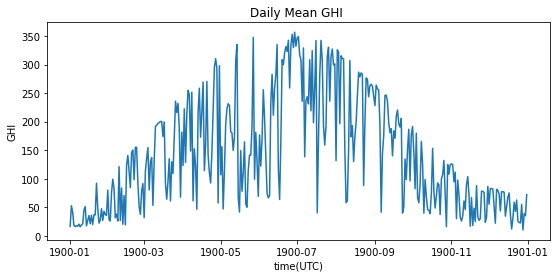

In [33]:
# plot mean by day

days = df.resample("D").mean()

f, ax = plt.subplots(figsize=(9,4))
ax = sns.lineplot(x=days.index, y="GHI", data=days)
ax.set_title("Daily Mean GHI ");

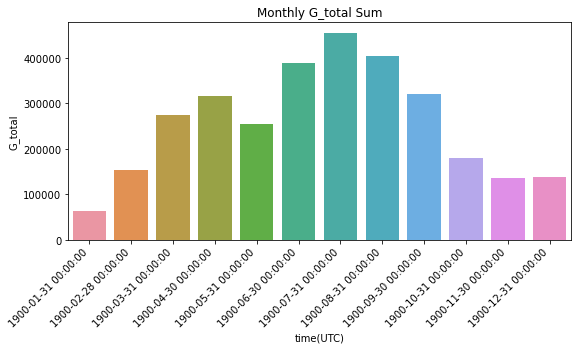

In [34]:
months = df.resample("M").sum()

f, ax = plt.subplots(figsize=(9,4))
ax = sns.barplot(x=months.index, y="G_total", data=months)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right');
ax.set_title("Monthly G_total Sum");

<AxesSubplot:xlabel='time(UTC)'>

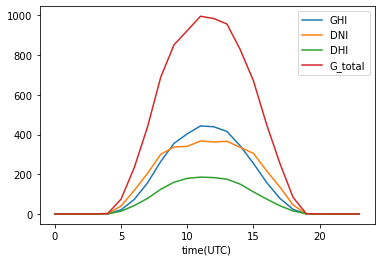

In [35]:
# Plot irradiance components' mean by hour of day.
df.groupby(df.index.hour).mean().plot()

<AxesSubplot:xlabel='time(UTC)', ylabel='time(UTC)'>

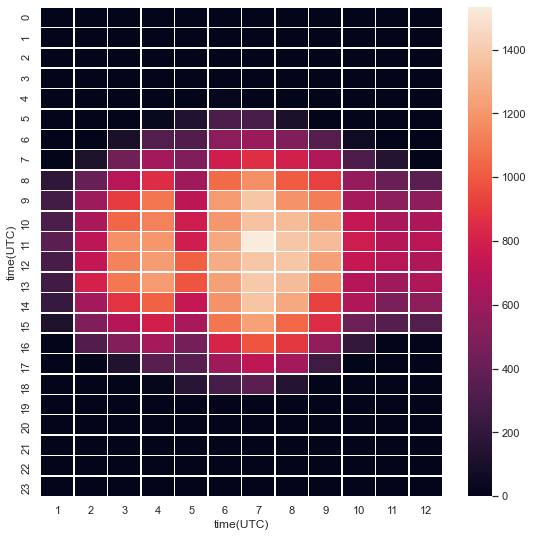

In [145]:
# Draw a total irradiance heatmap of hour by month

irrad = df["G_total"]

month_vs_hour = df.pivot_table(
    columns=df.index.month,
    index=df.index.hour,
    aggfunc="mean",
    values="G_total")

month_vs_hour

f, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(month_vs_hour, linewidths=.5, ax=ax)

Insights : 
- This TMY file has a very low production in the 5th month.
- Looking forward, not using horizon profiles might be a huge disadvantage for certain regions ...

Wall time: 104 ms


In [73]:
%%time
# transpose irradiance components to POA irradiance for a fixed tilts.

import pvlib
from pvlib import irradiance
from pvlib import location

# create location object to store lat, lon, timezone
deps_gps = pd.read_csv("./data/centres_geo_decimal.csv", dtype ={'code': str})



dep = deps_gps[deps_gps["code"]=="01"]

lat = dep["lat"][0]
lon = dep["lon"][0]


# Create location object to store lat, lon, timezone
site = location.Location(dep.lat.values[0], dep.lon.values[0])

def get_irradiance(site_location, tmy, times, tilt, surface_azimuth):
    
    solar_position = site_location.get_solarposition(times=times)

    POA_irradiance = irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=surface_azimuth,
        dni=tmy['DNI'],
        ghi=tmy['GHI'],
        dhi=tmy['DHI'],
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'])
    
    return pd.DataFrame({'POA': POA_irradiance['poa_global']})

get_irradiance(site, df[:1000] ,df.index[:1000], 0,0);




Wall time: 105 ms


,POA
time(UTC),
1900-01-01 00:00:00,0.000000
1900-01-01 01:00:00,0.000000
1900-01-01 02:00:00,0.000000
1900-01-01 03:00:00,0.000000
1900-01-01 04:00:00,0.000000
...,...
1900-02-11 11:00:00,256.619164
1900-02-11 12:00:00,306.171179
1900-02-11 13:00:00,417.169493


(144, 6)
(144, 6)


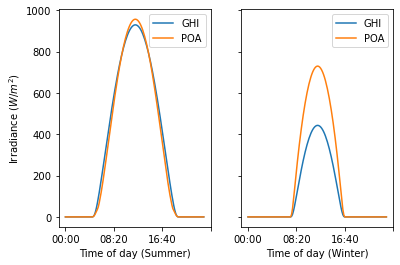

Wall time: 2.69 s


In [50]:
%%time

from pvlib import location
from pvlib import irradiance
import pandas as pd
from matplotlib import pyplot as plt

# For this example, we will be using Golden, Colorado
tz = 'MST'
lat, lon = 39.755, -105.221

# Create location object to store lat, lon, timezone
site = location.Location(lat, lon, tz=tz)


# Calculate clear-sky GHI and transpose to plane of array
# Define a function so that we can re-use the sequence of operations with
# different locations
def get_irradiance(site_location, date, tilt, surface_azimuth):
    # Creates one day's worth of 10 min intervals
    times = pd.date_range(date, freq='10min', periods=6*24,
                          tz=site_location.tz)
    # Generate clearsky data using the Ineichen model, which is the default
    # The get_clearsky method returns a dataframe with values for GHI, DNI,
    # and DHI
    clearsky = site_location.get_clearsky(times)
    # Get solar azimuth and zenith to pass to the transposition function
    print(solar_position.shape)
    # Use the get_total_irradiance function to transpose the GHI to POA
    POA_irradiance = irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=surface_azimuth,
        dni=clearsky['dni'],
        ghi=clearsky['ghi'],
        dhi=clearsky['dhi'],
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'])
    # Return DataFrame with only GHI and POA
    return pd.DataFrame({'GHI': clearsky['ghi'],
                         'POA': POA_irradiance['poa_global']})


# Get irradiance data for summer and winter solstice, assuming 25 degree tilt
# and a south facing array
summer_irradiance = get_irradiance(site, '06-20-2020', 25, 180)
winter_irradiance = get_irradiance(site, '12-21-2020', 25, 180)

# Convert Dataframe Indexes to Hour:Minute format to make plotting easier
summer_irradiance.index = summer_irradiance.index.strftime("%H:%M")
winter_irradiance.index = winter_irradiance.index.strftime("%H:%M")

# Plot GHI vs. POA for winter and summer
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
summer_irradiance['GHI'].plot(ax=ax1, label='GHI')
summer_irradiance['POA'].plot(ax=ax1, label='POA')
winter_irradiance['GHI'].plot(ax=ax2, label='GHI')
winter_irradiance['POA'].plot(ax=ax2, label='POA')
ax1.set_xlabel('Time of day (Summer)')
ax2.set_xlabel('Time of day (Winter)')
ax1.set_ylabel('Irradiance ($W/m^2$)')
ax1.legend()
ax2.legend()
plt.show()

In [51]:
solar_position

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
1899-12-31 23:30:00,156.837673,156.837673,-66.837673,-66.837673,352.951495,-3.42032
